In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

from sklearn.model_selection import StratifiedGroupKFold

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])
text_cols = ["LudRules",]

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))
print("Text features:", len(text_cols))

Numerical features: 296
Categorical features: 5
Text features: 1


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=True,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 370
Categorical Columns: 5


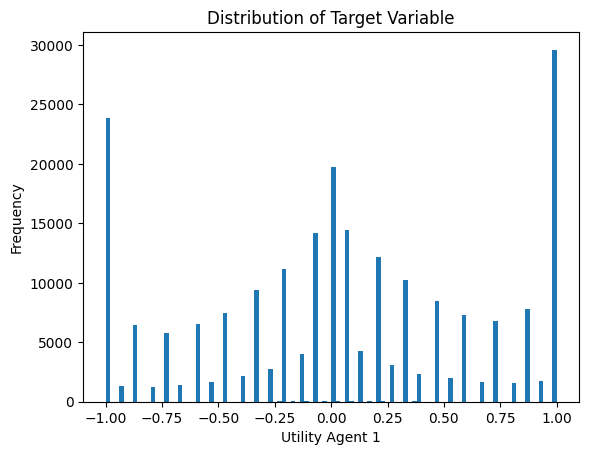

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

***
### train model

In [6]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [7]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        num_folds=5,
        cv_random_state=2112,
    ):
    # Define the number of folds for cross-validation
    group_col = "GameRulesetName"
    y_col = "utility_agent1_rank"
    gkf = StratifiedGroupKFold(n_splits=num_folds, random_state=cv_random_state, shuffle=True)
    split_list = gkf.split(df_train, groups=df_train[group_col], y=df_train[y_col])

    # Define the parameters for CatBoost
    params = {
        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }

        # Text processing parameters to mimic TF-IDF
        'tokenizers': [{
            'tokenizer_id': 'Space',
            'separator_type': 'ByDelimiter',
            'delimiter': ' '
        }],
        'dictionaries': [{
            'dictionary_id': 'NgramDict',
            'max_dictionary_size': '500',  # Match max_features=500
            'occurrence_lower_bound': '3',
            'gram_order': '3',  # Maximum n-gram size
            'min_gram_order': '2'  # Minimum n-gram size
        }],
        'feature_calcers': [{
            'calcer_type': 'BoW',  # Most similar to TF-IDF
            'dictionary_id': 'NgramDict'
        }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(index=df_train.index, columns=[f'{target}_true', f'{target}_pred'])
    oof_scores = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            data=X_train[numerical_cols + categorical_cols + text_cols],
            label=y_train,
            cat_features=categorical_cols,
            text_features=text_cols
        )
        val_pool = cb.Pool(
            data=X_valid[numerical_cols + categorical_cols + text_cols],
            label=y_valid,
            cat_features=categorical_cols,
            text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        plot_feature_importance(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)
        y_pred = np.clip(y_pred, -1, 1)
        
        # Compute RMSE on scaled values
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores

/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1
0:	learn: 0.6009023	test: 0.6039043	best: 0.6039043 (0)	total: 186ms	remaining: 9m 16s
50:	learn: 0.3922280	test: 0.4550859	best: 0.4550859 (50)	total: 6.43s	remaining: 6m 11s
100:	learn: 0.3567638	test: 0.4418212	best: 0.4418212 (100)	total: 12.9s	remaining: 6m 9s
150:	learn: 0.3358080	test: 0.4341501	best: 0.4341501 (150)	total: 19.1s	remaining: 5m 59s
200:	learn: 0.3229809	test: 0.4304916	best: 0.4304371 (198)	total: 25.5s	remaining: 5m 55s
250:	learn: 0.3125126	test: 0.4279054	best: 0.4279054 (250)	total: 31.8s	remaining: 5m 48s
300:	learn: 0.3039863	test: 0.4254372	best: 0.4254277 (299)	total: 38s	remaining: 5m 41s
350:	learn: 0.2967916	test: 0.4238684	best: 0.4238684 (350)	total: 44.3s	remaining: 5m 34s
400:	learn: 0.2910771	test: 0.4227190	best: 0.4227190 (400)	total: 50.7s	remaining: 5m 28s
450:	learn: 0.2851963	test: 0.4215260	best: 0.4215260 (450)	total: 57.1s	remaining: 5m 22s
500:	learn: 0.2803633	test: 0.4208129	best: 0.4208129 (500)	total: 1m 3s	remaining: 5m 16s
5

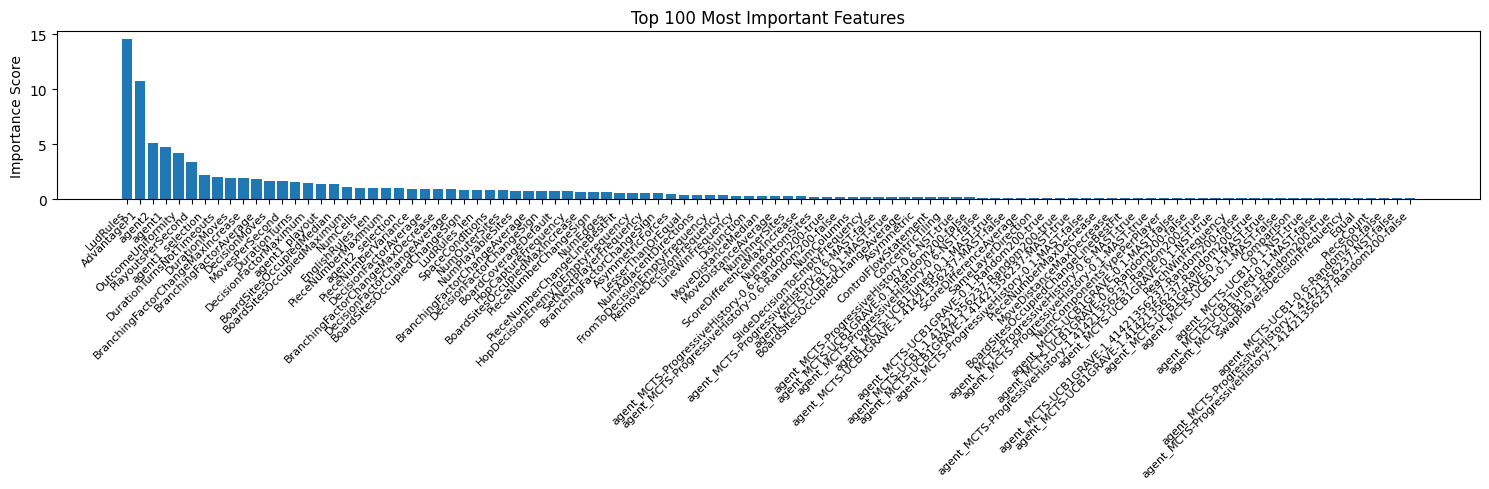

Fold 1 - RMSE: 0.41342973704981806
Fold 2
0:	learn: 0.5963279	test: 0.6174534	best: 0.6174534 (0)	total: 132ms	remaining: 6m 34s
50:	learn: 0.3884025	test: 0.4837650	best: 0.4837650 (50)	total: 6.26s	remaining: 6m 1s
100:	learn: 0.3556216	test: 0.4691494	best: 0.4691494 (100)	total: 12.5s	remaining: 6m
150:	learn: 0.3352583	test: 0.4622493	best: 0.4622493 (150)	total: 18.7s	remaining: 5m 53s
200:	learn: 0.3216116	test: 0.4579301	best: 0.4579301 (200)	total: 25s	remaining: 5m 48s
250:	learn: 0.3115775	test: 0.4544542	best: 0.4544542 (250)	total: 31.3s	remaining: 5m 43s
300:	learn: 0.3019848	test: 0.4520778	best: 0.4520778 (300)	total: 37.6s	remaining: 5m 37s
350:	learn: 0.2946590	test: 0.4510129	best: 0.4510129 (350)	total: 43.8s	remaining: 5m 30s
400:	learn: 0.2884092	test: 0.4500453	best: 0.4500453 (400)	total: 50.2s	remaining: 5m 25s
450:	learn: 0.2832007	test: 0.4490813	best: 0.4490813 (450)	total: 56.7s	remaining: 5m 20s
500:	learn: 0.2779868	test: 0.4485587	best: 0.4485587 (500)	t

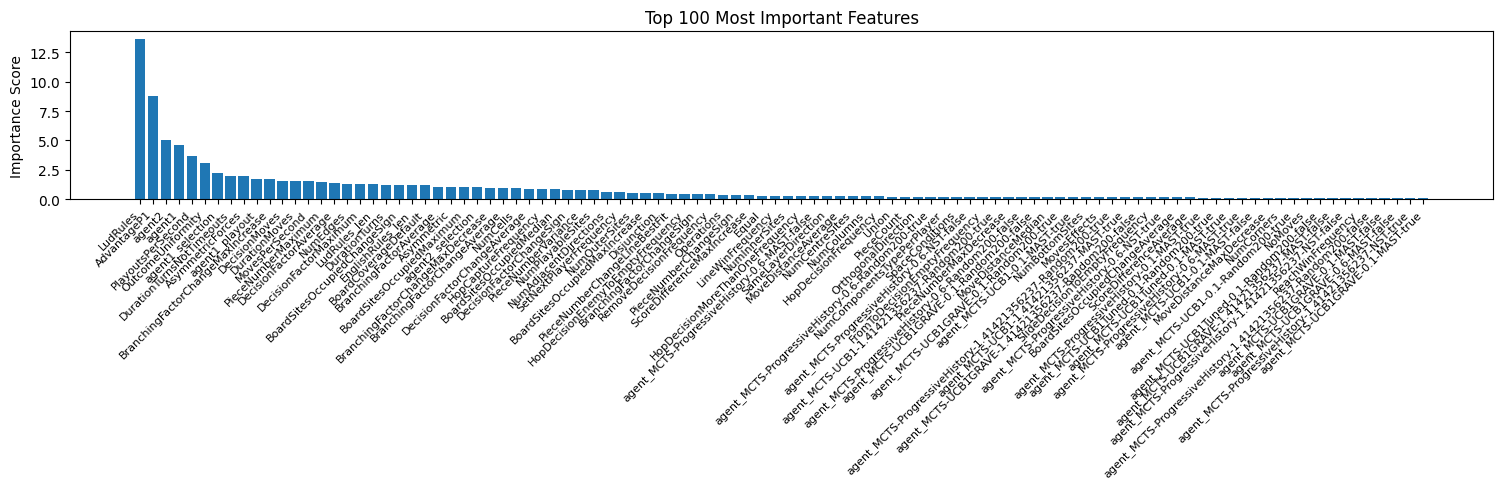

Fold 2 - RMSE: 0.43970849318577415
Fold 3
0:	learn: 0.6046412	test: 0.5855553	best: 0.5855553 (0)	total: 117ms	remaining: 5m 50s
50:	learn: 0.3939728	test: 0.4432605	best: 0.4432605 (50)	total: 6.54s	remaining: 6m 18s
100:	learn: 0.3595830	test: 0.4263733	best: 0.4263733 (100)	total: 13.1s	remaining: 6m 14s
150:	learn: 0.3384118	test: 0.4175969	best: 0.4175969 (150)	total: 19.6s	remaining: 6m 10s
200:	learn: 0.3246384	test: 0.4133355	best: 0.4133325 (199)	total: 26.5s	remaining: 6m 9s
250:	learn: 0.3135767	test: 0.4103761	best: 0.4103761 (250)	total: 33.2s	remaining: 6m 3s
300:	learn: 0.3044699	test: 0.4082607	best: 0.4082567 (298)	total: 39.8s	remaining: 5m 57s
350:	learn: 0.2969849	test: 0.4066198	best: 0.4066198 (350)	total: 46.5s	remaining: 5m 50s
400:	learn: 0.2900529	test: 0.4054777	best: 0.4054777 (400)	total: 53.1s	remaining: 5m 44s
450:	learn: 0.2847996	test: 0.4047075	best: 0.4047075 (450)	total: 59.9s	remaining: 5m 38s
500:	learn: 0.2796697	test: 0.4038972	best: 0.4038969 (4

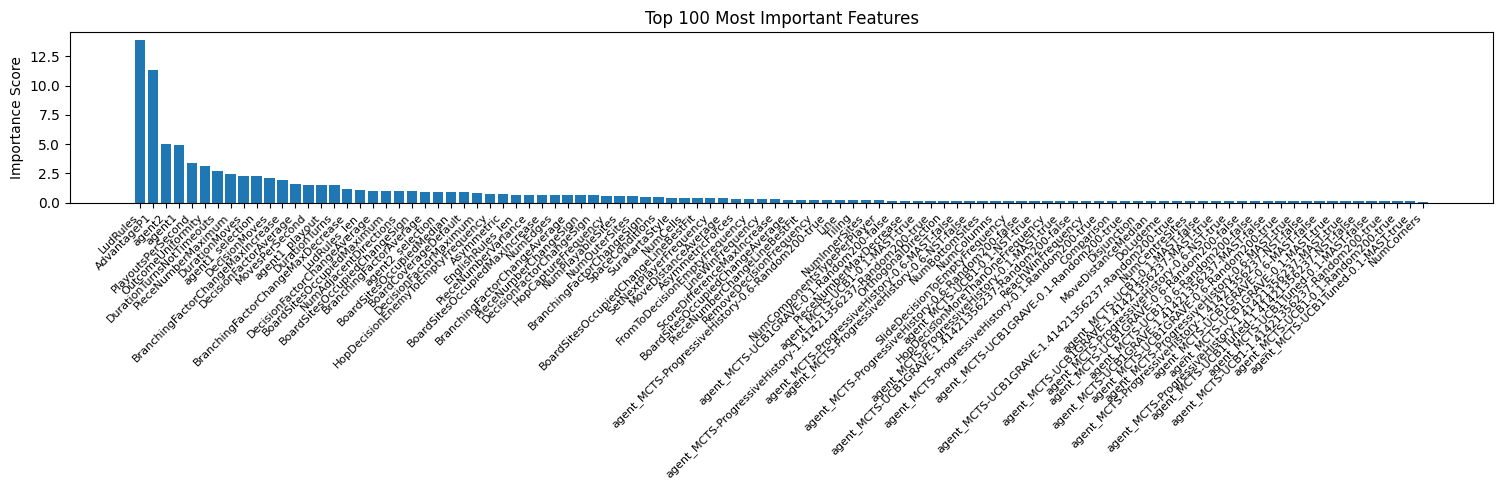

Fold 3 - RMSE: 0.3974247040186999
Fold 4
0:	learn: 0.5988726	test: 0.6155085	best: 0.6155085 (0)	total: 142ms	remaining: 7m 4s
50:	learn: 0.3916831	test: 0.4583292	best: 0.4583292 (50)	total: 6.67s	remaining: 6m 25s
100:	learn: 0.3579101	test: 0.4409408	best: 0.4409408 (100)	total: 13.6s	remaining: 6m 29s
150:	learn: 0.3366154	test: 0.4301860	best: 0.4301860 (150)	total: 20.4s	remaining: 6m 24s
200:	learn: 0.3228339	test: 0.4242519	best: 0.4242519 (200)	total: 27.2s	remaining: 6m 18s
250:	learn: 0.3128970	test: 0.4214034	best: 0.4213375 (249)	total: 34.2s	remaining: 6m 14s
300:	learn: 0.3043544	test: 0.4195701	best: 0.4195701 (300)	total: 41.1s	remaining: 6m 8s
350:	learn: 0.2970318	test: 0.4178577	best: 0.4178577 (350)	total: 48s	remaining: 6m 2s
400:	learn: 0.2903426	test: 0.4160373	best: 0.4160175 (399)	total: 54.9s	remaining: 5m 55s
450:	learn: 0.2848641	test: 0.4148655	best: 0.4148604 (448)	total: 1m 1s	remaining: 5m 49s
500:	learn: 0.2795140	test: 0.4136679	best: 0.4136679 (500)	

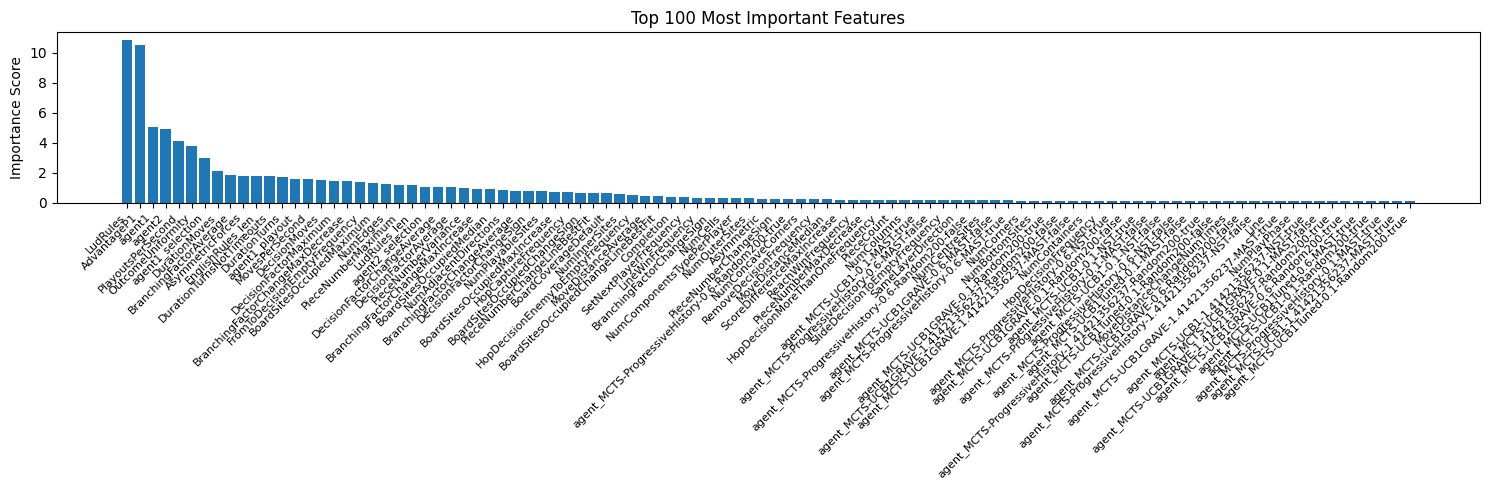

Fold 4 - RMSE: 0.4024689019667699
Fold 5
0:	learn: 0.5995353	test: 0.6114683	best: 0.6114683 (0)	total: 124ms	remaining: 6m 11s
50:	learn: 0.3935530	test: 0.4665725	best: 0.4665725 (50)	total: 6.6s	remaining: 6m 21s
100:	learn: 0.3578407	test: 0.4512583	best: 0.4512583 (100)	total: 13.3s	remaining: 6m 22s
150:	learn: 0.3377372	test: 0.4442397	best: 0.4441569 (149)	total: 20s	remaining: 6m 18s
200:	learn: 0.3249651	test: 0.4400706	best: 0.4400706 (200)	total: 26.7s	remaining: 6m 12s
250:	learn: 0.3141117	test: 0.4372041	best: 0.4371868 (248)	total: 33.5s	remaining: 6m 7s
300:	learn: 0.3052730	test: 0.4349216	best: 0.4349216 (300)	total: 40.3s	remaining: 6m 1s
350:	learn: 0.2979392	test: 0.4334394	best: 0.4334394 (350)	total: 47.2s	remaining: 5m 56s
400:	learn: 0.2918985	test: 0.4323633	best: 0.4323633 (400)	total: 54s	remaining: 5m 50s
450:	learn: 0.2862976	test: 0.4316418	best: 0.4316418 (450)	total: 1m	remaining: 5m 44s
500:	learn: 0.2811460	test: 0.4305852	best: 0.4305852 (500)	total

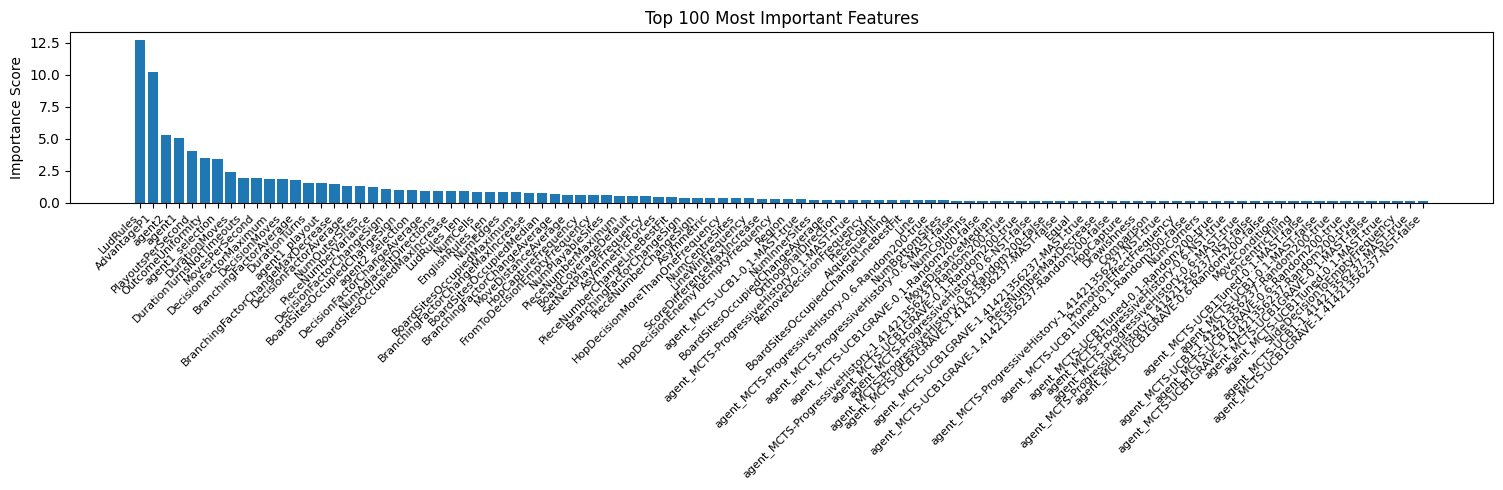

Fold 5 - RMSE: 0.4216662353106553
List of oof scores: [0.41342973704981806, 0.43970849318577415, 0.3974247040186999, 0.4024689019667699, 0.4216662353106553]
Average oof score: 0.4149396143063434


In [8]:
# call the function
trained_models1, oof1, oof_scores1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    num_folds=5,
    cv_random_state=2112,
)

/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1
0:	learn: 0.6025748	test: 0.6021925	best: 0.6021925 (0)	total: 128ms	remaining: 6m 22s
50:	learn: 0.3959315	test: 0.4611362	best: 0.4611362 (50)	total: 6.77s	remaining: 6m 31s
100:	learn: 0.3585934	test: 0.4400168	best: 0.4400168 (100)	total: 13.7s	remaining: 6m 32s
150:	learn: 0.3401230	test: 0.4324174	best: 0.4324174 (150)	total: 20.4s	remaining: 6m 25s
200:	learn: 0.3265758	test: 0.4282268	best: 0.4282268 (200)	total: 27.4s	remaining: 6m 21s
250:	learn: 0.3155939	test: 0.4244029	best: 0.4243225 (247)	total: 34.3s	remaining: 6m 15s
300:	learn: 0.3067257	test: 0.4218729	best: 0.4218729 (300)	total: 41.2s	remaining: 6m 9s
350:	learn: 0.2998575	test: 0.4206273	best: 0.4205873 (349)	total: 48.2s	remaining: 6m 4s
400:	learn: 0.2925117	test: 0.4191614	best: 0.4191614 (400)	total: 55.2s	remaining: 5m 57s
450:	learn: 0.2863806	test: 0.4176912	best: 0.4176912 (450)	total: 1m 2s	remaining: 5m 50s
500:	learn: 0.2808743	test: 0.4164770	best: 0.4164770 (500)	total: 1m 9s	remaining: 5m 44s


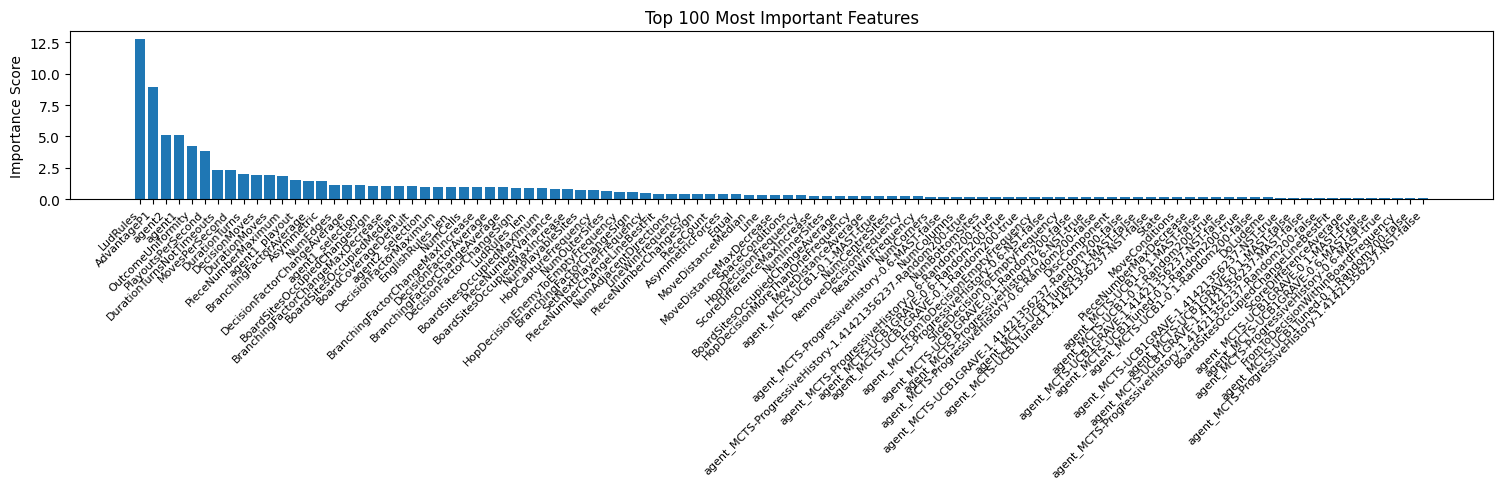

Fold 1 - RMSE: 0.4088262840160336
Fold 2
0:	learn: 0.5957076	test: 0.6138668	best: 0.6138668 (0)	total: 127ms	remaining: 6m 21s
50:	learn: 0.3915557	test: 0.4562709	best: 0.4562709 (50)	total: 6.68s	remaining: 6m 26s
100:	learn: 0.3567775	test: 0.4416750	best: 0.4416273 (98)	total: 13.5s	remaining: 6m 26s
150:	learn: 0.3356606	test: 0.4330118	best: 0.4330118 (150)	total: 20.2s	remaining: 6m 20s
200:	learn: 0.3225659	test: 0.4292507	best: 0.4292507 (200)	total: 27s	remaining: 6m 15s
250:	learn: 0.3115122	test: 0.4265722	best: 0.4265722 (250)	total: 33.8s	remaining: 6m 10s
300:	learn: 0.3029077	test: 0.4245121	best: 0.4245121 (300)	total: 40.7s	remaining: 6m 4s
350:	learn: 0.2957522	test: 0.4234875	best: 0.4234875 (350)	total: 47.5s	remaining: 5m 58s
400:	learn: 0.2897374	test: 0.4225098	best: 0.4224759 (399)	total: 54.4s	remaining: 5m 52s
450:	learn: 0.2839081	test: 0.4216218	best: 0.4215829 (448)	total: 1m 1s	remaining: 5m 46s
500:	learn: 0.2789667	test: 0.4207206	best: 0.4206977 (499)

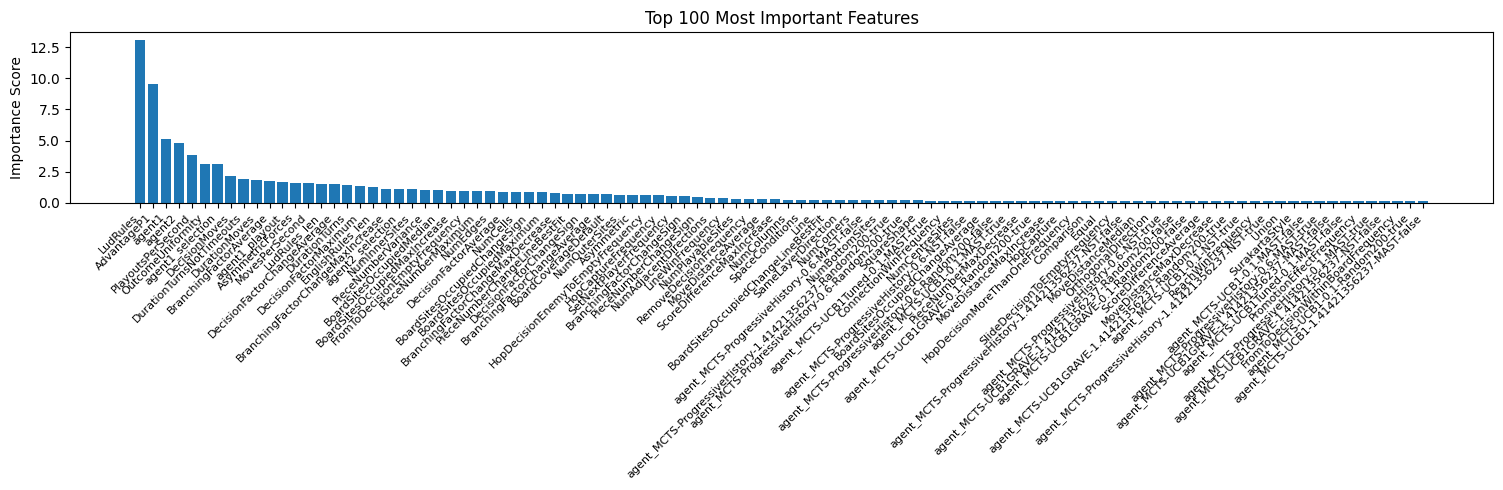

Fold 2 - RMSE: 0.41217542622935166
Fold 3
0:	learn: 0.6061741	test: 0.5868833	best: 0.5868833 (0)	total: 127ms	remaining: 6m 21s
50:	learn: 0.3912714	test: 0.4676344	best: 0.4676344 (50)	total: 6.65s	remaining: 6m 24s
100:	learn: 0.3575491	test: 0.4536076	best: 0.4535089 (97)	total: 13.5s	remaining: 6m 27s
150:	learn: 0.3378604	test: 0.4462615	best: 0.4462615 (150)	total: 20.2s	remaining: 6m 21s
200:	learn: 0.3235280	test: 0.4413802	best: 0.4413802 (200)	total: 27s	remaining: 6m 15s
250:	learn: 0.3127940	test: 0.4378940	best: 0.4378940 (250)	total: 33.8s	remaining: 6m 10s
300:	learn: 0.3038722	test: 0.4351611	best: 0.4351611 (300)	total: 40.5s	remaining: 6m 3s
350:	learn: 0.2965403	test: 0.4334545	best: 0.4334545 (350)	total: 47.3s	remaining: 5m 57s
400:	learn: 0.2901205	test: 0.4318961	best: 0.4318961 (400)	total: 54.4s	remaining: 5m 52s
450:	learn: 0.2841560	test: 0.4305571	best: 0.4305571 (450)	total: 1m 1s	remaining: 5m 48s
500:	learn: 0.2791364	test: 0.4294984	best: 0.4294617 (491

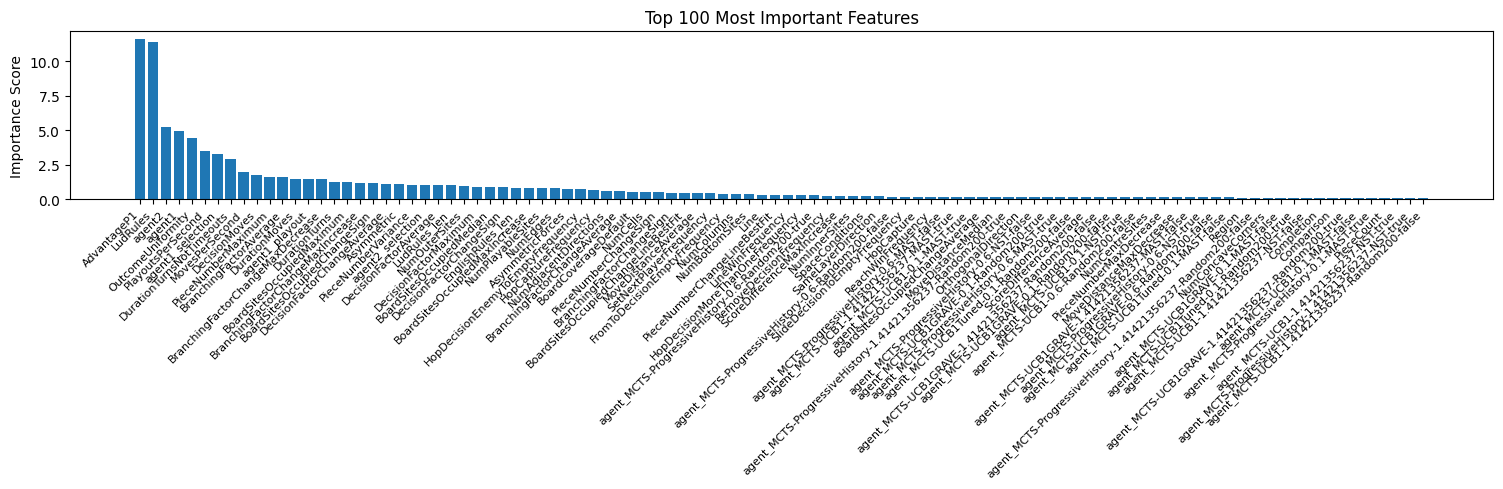

Fold 3 - RMSE: 0.4212283335405584
Fold 4
0:	learn: 0.5989643	test: 0.6110247	best: 0.6110247 (0)	total: 122ms	remaining: 6m 5s
50:	learn: 0.3927755	test: 0.4611689	best: 0.4611689 (50)	total: 7.38s	remaining: 7m 6s
100:	learn: 0.3573280	test: 0.4442117	best: 0.4442117 (100)	total: 14.1s	remaining: 6m 44s
150:	learn: 0.3382904	test: 0.4361542	best: 0.4361542 (150)	total: 20.7s	remaining: 6m 30s
200:	learn: 0.3239720	test: 0.4315231	best: 0.4315231 (200)	total: 27.5s	remaining: 6m 22s
250:	learn: 0.3126693	test: 0.4279424	best: 0.4279424 (250)	total: 34.2s	remaining: 6m 14s
300:	learn: 0.3042399	test: 0.4263719	best: 0.4263398 (294)	total: 41s	remaining: 6m 7s
350:	learn: 0.2965656	test: 0.4250391	best: 0.4250391 (350)	total: 47.6s	remaining: 5m 59s
400:	learn: 0.2903384	test: 0.4238114	best: 0.4238114 (400)	total: 54.4s	remaining: 5m 52s
450:	learn: 0.2841613	test: 0.4228166	best: 0.4228166 (450)	total: 1m 1s	remaining: 5m 45s
500:	learn: 0.2787165	test: 0.4217926	best: 0.4217926 (500)	

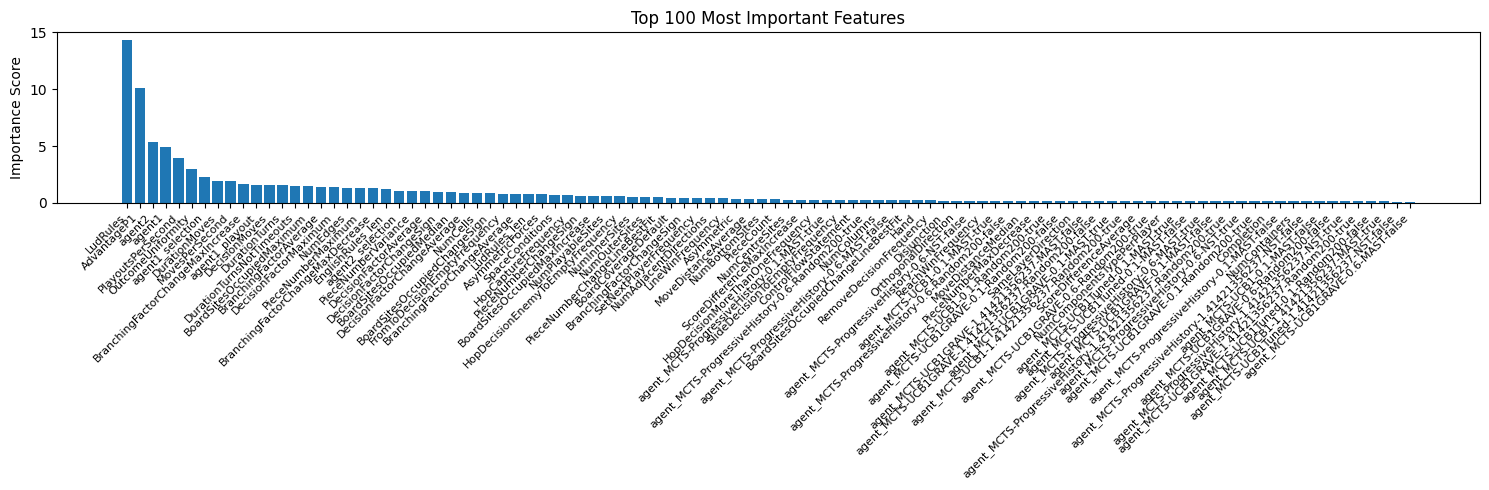

Fold 4 - RMSE: 0.4136784694225206
Fold 5
0:	learn: 0.5973832	test: 0.6174686	best: 0.6174686 (0)	total: 135ms	remaining: 6m 44s
50:	learn: 0.3936495	test: 0.4775572	best: 0.4775572 (50)	total: 6.61s	remaining: 6m 21s
100:	learn: 0.3562177	test: 0.4617789	best: 0.4617789 (100)	total: 13.4s	remaining: 6m 25s
150:	learn: 0.3350383	test: 0.4535524	best: 0.4535524 (150)	total: 20.1s	remaining: 6m 20s
200:	learn: 0.3214081	test: 0.4501293	best: 0.4501293 (200)	total: 26.8s	remaining: 6m 13s
250:	learn: 0.3112881	test: 0.4479201	best: 0.4479201 (250)	total: 33.6s	remaining: 6m 8s
300:	learn: 0.3027680	test: 0.4461116	best: 0.4460529 (294)	total: 40.3s	remaining: 6m 1s
350:	learn: 0.2953781	test: 0.4444969	best: 0.4444969 (350)	total: 47.2s	remaining: 5m 56s
400:	learn: 0.2892354	test: 0.4434650	best: 0.4434483 (397)	total: 54s	remaining: 5m 49s
450:	learn: 0.2835055	test: 0.4424045	best: 0.4424045 (450)	total: 1m	remaining: 5m 44s
500:	learn: 0.2786121	test: 0.4414556	best: 0.4414556 (500)	to

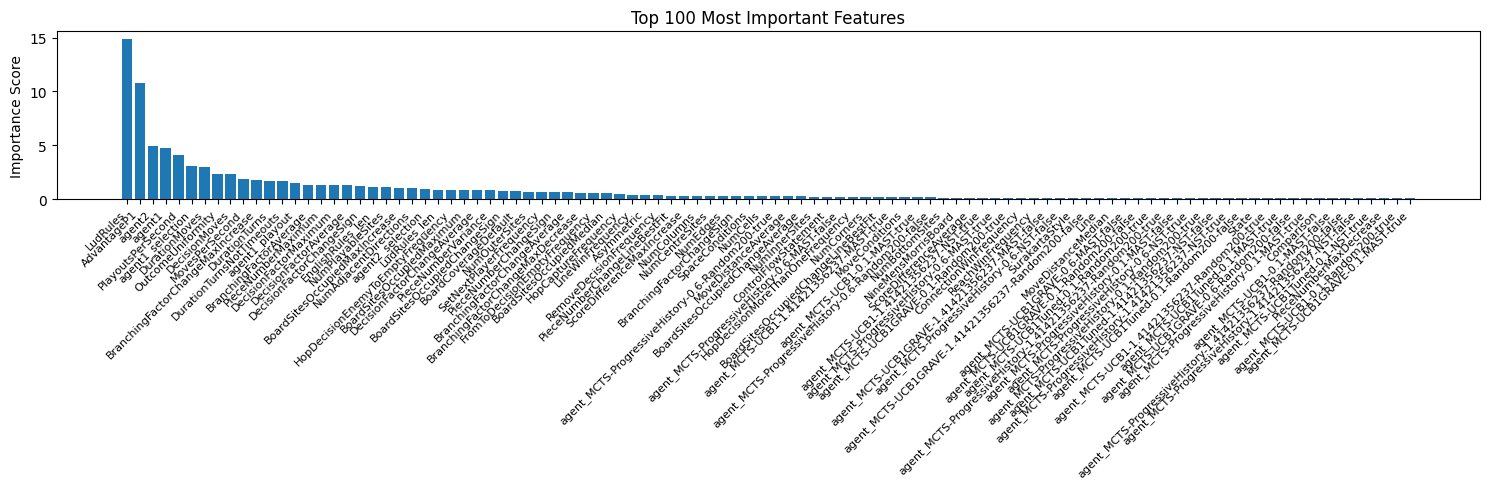

Fold 5 - RMSE: 0.4353810838705507
List of oof scores: [0.4088262840160336, 0.41217542622935166, 0.4212283335405584, 0.4136784694225206, 0.4353810838705507]
Average oof score: 0.418257919415803


In [9]:
# call the function
trained_models2, oof2, oof_scores2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    num_folds=5,
    cv_random_state=19,
)
# save oof predictions
oof2.to_csv(path_results / 'oof_catboost_cv2.csv', index=False)

/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1
0:	learn: 0.6015236	test: 0.6012277	best: 0.6012277 (0)	total: 114ms	remaining: 5m 41s
50:	learn: 0.3910193	test: 0.4568947	best: 0.4568947 (50)	total: 6.6s	remaining: 6m 21s
100:	learn: 0.3591796	test: 0.4436549	best: 0.4436549 (100)	total: 13.4s	remaining: 6m 24s
150:	learn: 0.3382665	test: 0.4353345	best: 0.4353345 (150)	total: 20.1s	remaining: 6m 19s
200:	learn: 0.3236027	test: 0.4303053	best: 0.4303053 (200)	total: 26.9s	remaining: 6m 14s
250:	learn: 0.3125495	test: 0.4270627	best: 0.4270627 (250)	total: 33.7s	remaining: 6m 8s
300:	learn: 0.3038136	test: 0.4241925	best: 0.4241925 (300)	total: 40.4s	remaining: 6m 2s
350:	learn: 0.2968096	test: 0.4226724	best: 0.4226724 (350)	total: 47.3s	remaining: 5m 56s
400:	learn: 0.2900449	test: 0.4209482	best: 0.4209482 (400)	total: 54.1s	remaining: 5m 50s
450:	learn: 0.2840545	test: 0.4200393	best: 0.4200393 (450)	total: 1m	remaining: 5m 43s
500:	learn: 0.2787912	test: 0.4191552	best: 0.4191552 (500)	total: 1m 7s	remaining: 5m 37s
550:

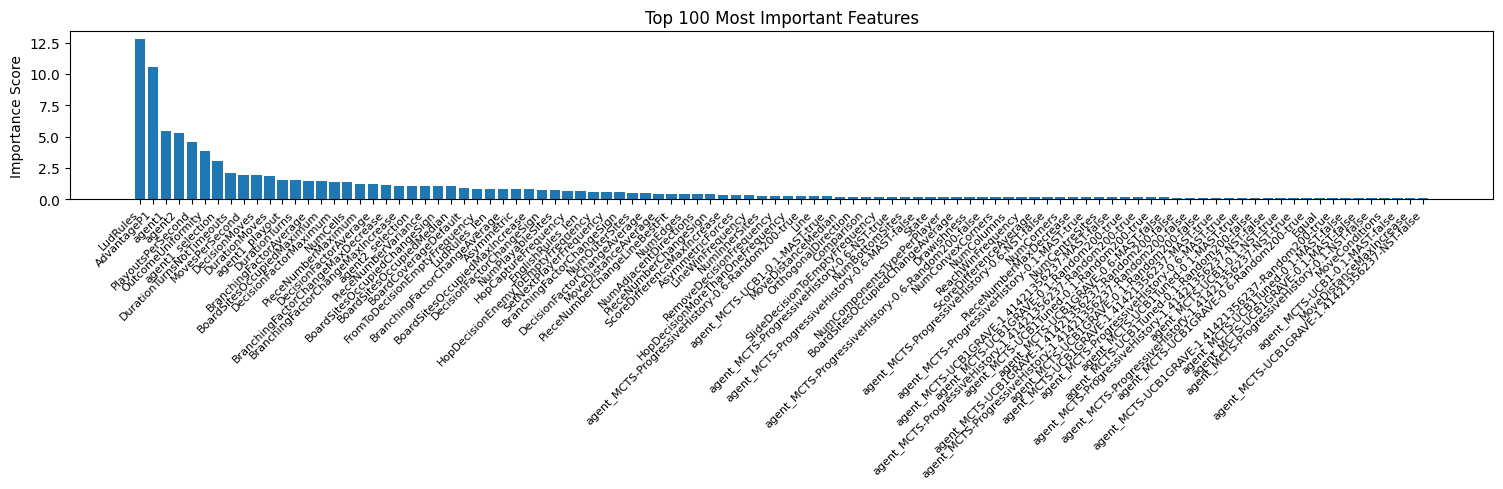

Fold 1 - RMSE: 0.40831187460109836
Fold 2
0:	learn: 0.5997409	test: 0.6080425	best: 0.6080425 (0)	total: 122ms	remaining: 6m 5s
50:	learn: 0.3871110	test: 0.4735736	best: 0.4735736 (50)	total: 6.61s	remaining: 6m 22s
100:	learn: 0.3528551	test: 0.4608213	best: 0.4608213 (100)	total: 13.4s	remaining: 6m 24s
150:	learn: 0.3322471	test: 0.4529160	best: 0.4529160 (150)	total: 20.1s	remaining: 6m 19s
200:	learn: 0.3189056	test: 0.4486253	best: 0.4486253 (200)	total: 26.8s	remaining: 6m 13s
250:	learn: 0.3081545	test: 0.4452549	best: 0.4452549 (250)	total: 33.5s	remaining: 6m 6s
300:	learn: 0.3001783	test: 0.4439570	best: 0.4439570 (300)	total: 40.3s	remaining: 6m 1s
350:	learn: 0.2929361	test: 0.4421713	best: 0.4421713 (350)	total: 47s	remaining: 5m 54s
400:	learn: 0.2867274	test: 0.4411982	best: 0.4411982 (400)	total: 53.8s	remaining: 5m 48s
450:	learn: 0.2811954	test: 0.4399487	best: 0.4399487 (450)	total: 1m	remaining: 5m 42s
500:	learn: 0.2763341	test: 0.4392907	best: 0.4392595 (496)	to

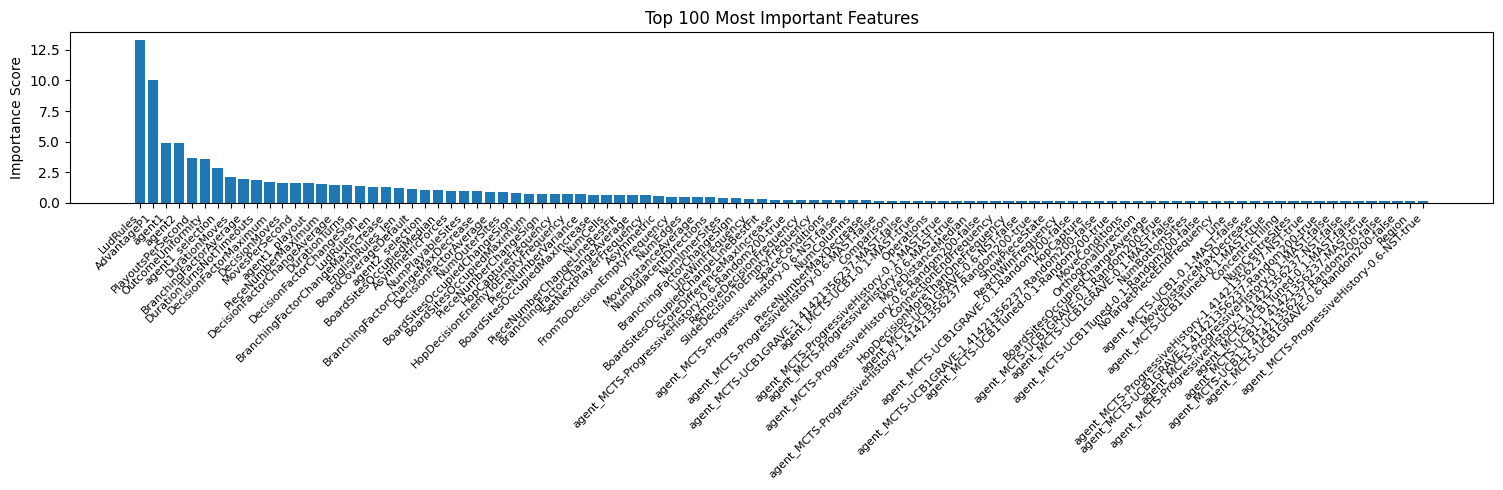

Fold 2 - RMSE: 0.43079006441998813
Fold 3
0:	learn: 0.5986835	test: 0.6022700	best: 0.6022700 (0)	total: 130ms	remaining: 6m 30s
50:	learn: 0.3897239	test: 0.4635666	best: 0.4635666 (50)	total: 6.64s	remaining: 6m 23s
100:	learn: 0.3562500	test: 0.4468332	best: 0.4468332 (100)	total: 13.3s	remaining: 6m 23s
150:	learn: 0.3368208	test: 0.4379664	best: 0.4379664 (150)	total: 20s	remaining: 6m 17s
200:	learn: 0.3236448	test: 0.4332494	best: 0.4332494 (200)	total: 26.8s	remaining: 6m 13s
250:	learn: 0.3122498	test: 0.4298999	best: 0.4298999 (250)	total: 33.6s	remaining: 6m 8s
300:	learn: 0.3036490	test: 0.4282608	best: 0.4282608 (300)	total: 40.4s	remaining: 6m 2s
350:	learn: 0.2965061	test: 0.4268040	best: 0.4267886 (349)	total: 47.1s	remaining: 5m 55s
400:	learn: 0.2901072	test: 0.4258013	best: 0.4258013 (400)	total: 53.9s	remaining: 5m 49s
450:	learn: 0.2844407	test: 0.4243874	best: 0.4243874 (449)	total: 1m	remaining: 5m 43s
500:	learn: 0.2795998	test: 0.4231385	best: 0.4231385 (500)	t

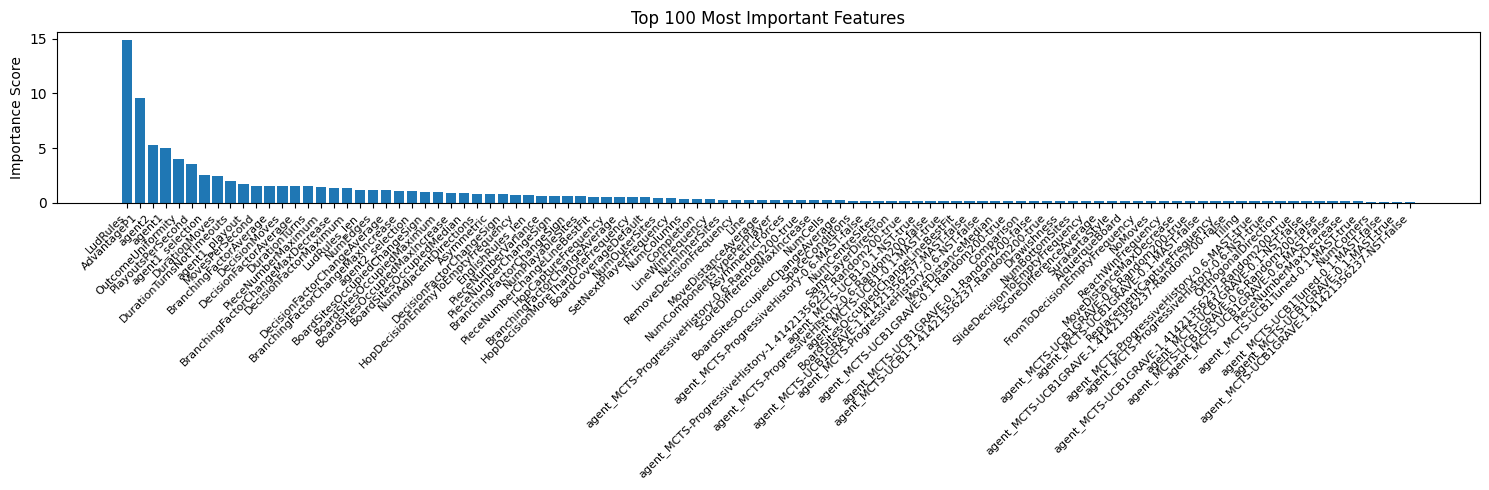

Fold 3 - RMSE: 0.4157724678891977
Fold 4
0:	learn: 0.5897421	test: 0.6363517	best: 0.6363517 (0)	total: 119ms	remaining: 5m 57s
50:	learn: 0.3914283	test: 0.4685425	best: 0.4685425 (50)	total: 6.61s	remaining: 6m 22s
100:	learn: 0.3560664	test: 0.4518380	best: 0.4518129 (97)	total: 13.4s	remaining: 6m 23s
150:	learn: 0.3367585	test: 0.4447728	best: 0.4447664 (147)	total: 20.1s	remaining: 6m 19s
200:	learn: 0.3236811	test: 0.4408719	best: 0.4408719 (200)	total: 26.9s	remaining: 6m 14s
250:	learn: 0.3130517	test: 0.4382614	best: 0.4382614 (250)	total: 33.6s	remaining: 6m 8s
300:	learn: 0.3047665	test: 0.4362495	best: 0.4362495 (300)	total: 40.4s	remaining: 6m 2s
350:	learn: 0.2978937	test: 0.4346220	best: 0.4346220 (350)	total: 47.1s	remaining: 5m 55s
400:	learn: 0.2911243	test: 0.4329969	best: 0.4329471 (399)	total: 53.9s	remaining: 5m 49s
450:	learn: 0.2853285	test: 0.4320145	best: 0.4320145 (450)	total: 1m	remaining: 5m 42s
500:	learn: 0.2804118	test: 0.4314693	best: 0.4314679 (499)	t

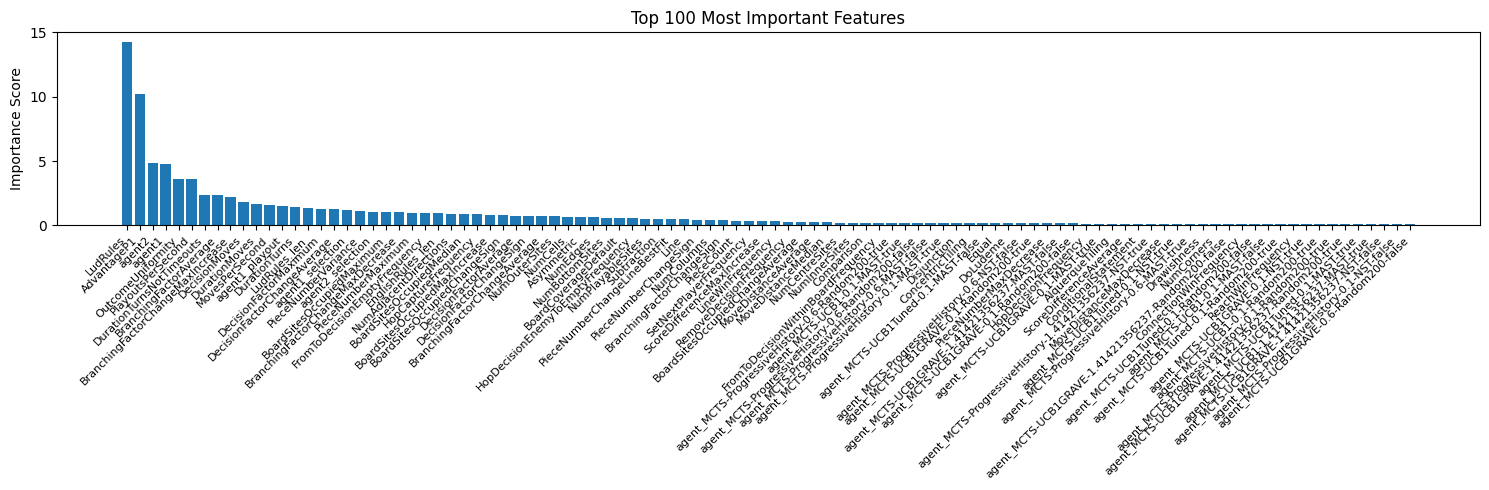

Fold 4 - RMSE: 0.4222671805959374
Fold 5
0:	learn: 0.6082126	test: 0.5715250	best: 0.5715250 (0)	total: 128ms	remaining: 6m 23s
50:	learn: 0.3965867	test: 0.4201083	best: 0.4201083 (50)	total: 6.43s	remaining: 6m 12s
100:	learn: 0.3616844	test: 0.4015104	best: 0.4015104 (100)	total: 13.1s	remaining: 6m 17s
150:	learn: 0.3400115	test: 0.3926385	best: 0.3926385 (150)	total: 19.8s	remaining: 6m 13s
200:	learn: 0.3259718	test: 0.3874344	best: 0.3874344 (200)	total: 26.4s	remaining: 6m 7s
250:	learn: 0.3148793	test: 0.3842800	best: 0.3842800 (250)	total: 33s	remaining: 6m 1s
300:	learn: 0.3058642	test: 0.3815361	best: 0.3815361 (300)	total: 39.8s	remaining: 5m 56s
350:	learn: 0.2983276	test: 0.3797211	best: 0.3797211 (350)	total: 46.5s	remaining: 5m 50s
400:	learn: 0.2913187	test: 0.3781707	best: 0.3781707 (400)	total: 53.2s	remaining: 5m 45s
450:	learn: 0.2858943	test: 0.3773383	best: 0.3773383 (450)	total: 1m	remaining: 5m 39s
500:	learn: 0.2809388	test: 0.3762973	best: 0.3762390 (499)	to

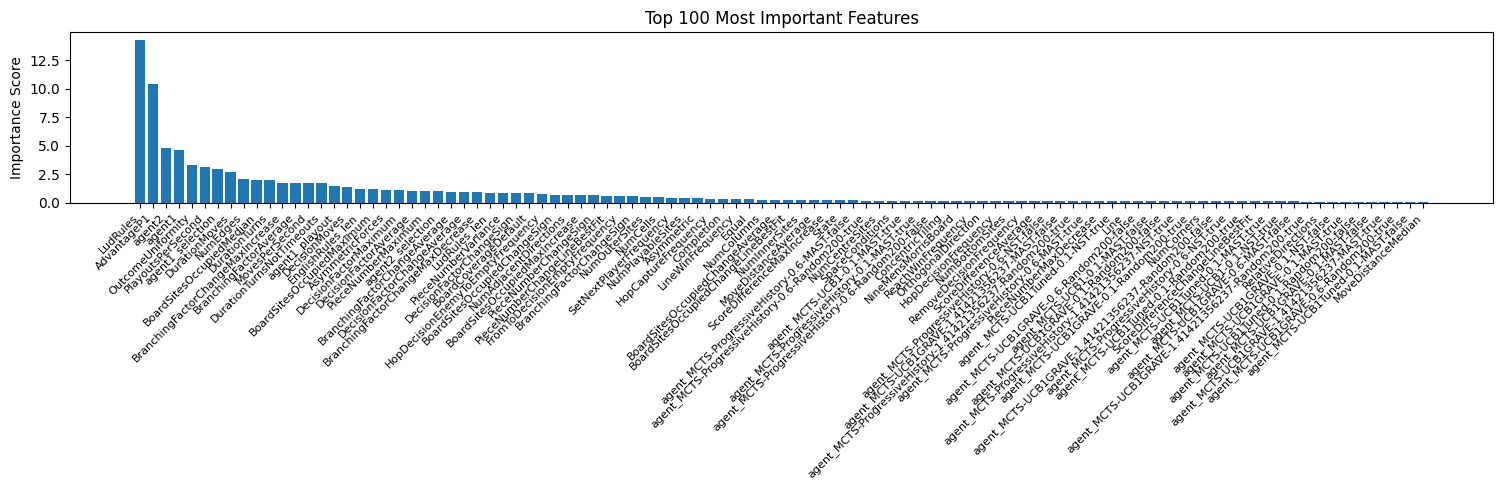

Fold 5 - RMSE: 0.3670946280027302
List of oof scores: [0.40831187460109836, 0.43079006441998813, 0.4157724678891977, 0.4222671805959374, 0.3670946280027302]
Average oof score: 0.4088472431017903


In [10]:
# call the function
trained_models3, oof3, oof_scores3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    num_folds=5,
    cv_random_state=23,
)
# save oof predictions
oof3.to_csv(path_results / 'oof_catboost_cv3.csv', index=False)

In [11]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]

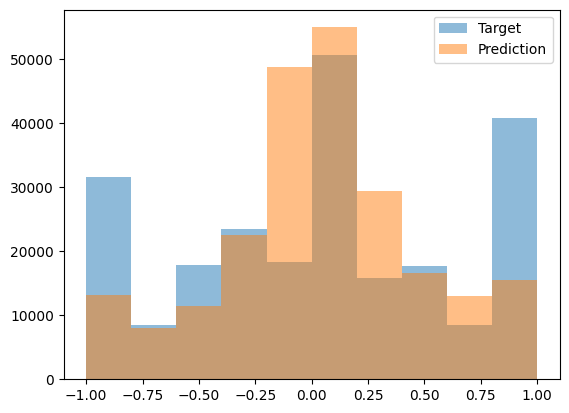

In [12]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [13]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [14]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        data=test_processed[numerical_cols + categorical_cols + text_cols],
        cat_features=categorical_cols,
        text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [15]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.135493       │
│ 233235 ┆ -0.169496      │
│ 233236 ┆ -0.034781      │
└────────┴────────────────┘

In [16]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [17]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}

with open('./catboost_predict.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***
